In [1]:
# ! pip install -U matplotlib
# ! pip install -U numpy
# ! pip install -U scipy
# ! pip install ipympl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [3]:
def plot(*args):
    for idx in range(0, len(args), 2):
        x, y = args[idx], args[idx + 1]
        plt.plot(x, y)
    plt.grid(True)
    plt.ylabel('y')
    plt.xlabel('x')
    plt.show()

In [4]:
def plot_surface(*args):
    figure = plt.figure()
    ax = figure.add_subplot(projection="3d")
    for idx in range(0, len(args), 3):
        x, y, z = args[idx], args[idx + 1], args[idx + 2]
        ax.plot_(x, y, z)
    plt.grid(True)
    plt.ylabel('y')
    plt.xlabel('x')
    plt.show()

### Частотно-временные способы анализа сигналов с применением преобразованием Фурье


In [5]:
def dft(array: np.ndarray) -> np.ndarray:
    """ Discrete Fourier Transform"""
    def discrete_fourier_function(
        array: np.ndarray,
        k: int
    ) -> np.imag:

        def F(item, n):
            return item * np.e ** (
                (-1) * ((2 * np.pi * k * n * 1j) /
                        array.size - 1)
            )

        result = np.zeros(array.size, dtype=np.complex_)
        for idx in range(array.size):
            result[idx] = F(array[idx], idx)
        return np.sum(result)

    result = np.zeros(array.shape, dtype=np.complex_)
    for idx in range(array.size):
        result[idx] = discrete_fourier_function(array, idx)
    return result

In [6]:
def specter(array: np.ndarray) -> np.ndarray:
    tmp_freqs = np.abs(array)
    tmp_freqs = tmp_freqs[tmp_freqs.size // 2:]
    return 2 * tmp_freqs / array.size

In [13]:
def fragmentize(
        array: np.ndarray,
        size: int) -> np.ndarray:
    fragments = np.array_split(array, range(size, array.size, size))
    fragments = np.array(fragments)
    return fragments

In [14]:
def stft(array: np.ndarray):
    """Short Timed Fourier Transform"""
    tmp = []
    for part in array:
        tmp.append(specter(part))
    return np.array(tmp)

In [15]:
def y(x):
    if x < np.pi:
        return np.sin(0.5 * 2 * np.pi * x)
    else:
        return np.sin(0.8 * 2 * np.pi * x)

In [16]:
def make_bins(values: np.ndarray):
    """
    Создаём диапазоны для частей, 
    где за горизонтальное значение берётся
    индекс части, а по вертикали не/попадание
    в диапазон данных
    """
    bins = np.linspace(np.min(values), np.max(values), num=50)
    binned = np.zeros(shape=(bins.shape[0], values.shape[0]), dtype=np.int8)

    for line_idx in range(len(values)):
        for el_idx in range(values[line_idx].size):
            """Итерируемся по значениям частот"""
            current_value = values[line_idx, el_idx]

            for bin_idx in range(0, bins.size, 2):
                high_value = bins[bin_idx + 1]
                """
                Если частота попала в диапазон относительно
                большего значения поддиапозона, то выставляем попадание
                """
                if high_value >= current_value:
                    binned[bin_idx - 1, line_idx] = 1
                    break

    """Добавляем ещё одно значение для pcolormesh (иначе график не будет отрисовываться)"""
    bins = np.append(bins, np.max(values) + bins[0] - bins[1])
    return bins, binned

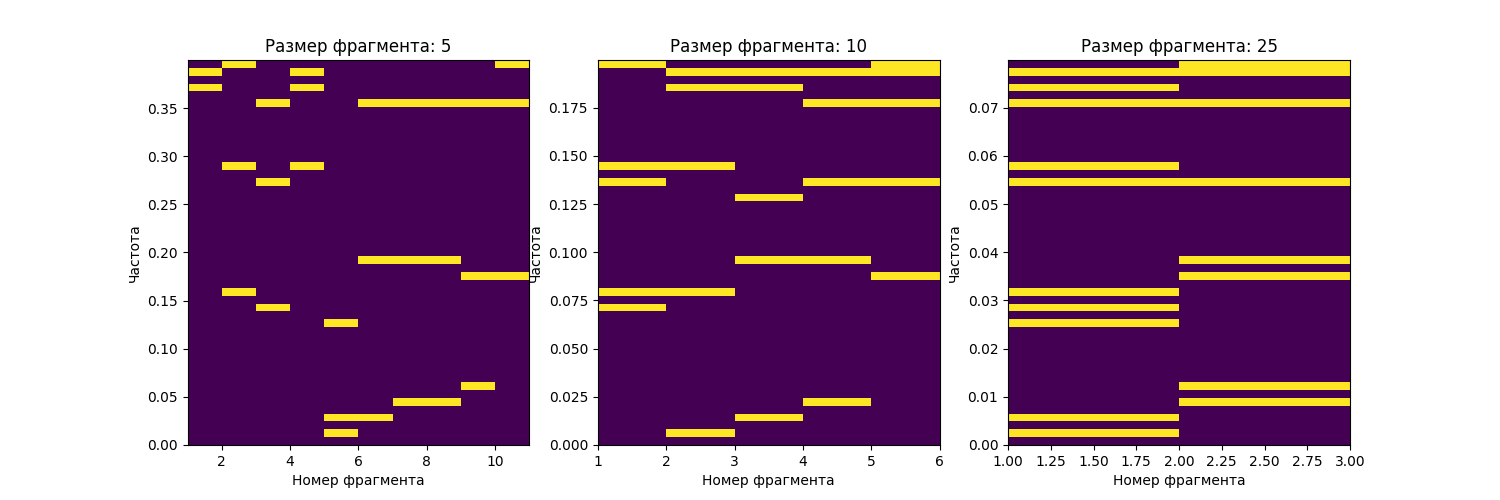

In [17]:
SAMPLES_COUNT = 50
signal_array = np.zeros(SAMPLES_COUNT)
for i in range(1, SAMPLES_COUNT):
    signal_array[i - 1] = y((2 * np.pi * i) / SAMPLES_COUNT)

SIZES = [5, 10, 25]
fig, axs = plt.subplots(nrows=1, ncols=len(SIZES), figsize=(15, 5))
for idx, size in enumerate(SIZES):
    fragment_size = size
    fragments = fragmentize(signal_array, fragment_size)
    stft_array = stft(fragments)

    bins, values = make_bins(stft_array)
    x_graph = np.arange(1, fragments.shape[0] + 2)
    y_graph = bins
    z_graph = values

    axs[idx].set_title(f'Размер фрагмента: {fragment_size}')
    axs[idx].set_ylabel(f'Частота')
    axs[idx].set_xlabel(f'Номер фрагмента')
    axs[idx].pcolormesh(
        x_graph,
        y_graph,
        z_graph,
        shading='flat',
        vmin=stft_array.min(),
        vmax=stft_array.max())

### Оконное преобразование Фурье